# LSTM Production
Notebook to put LSTM into production on AWS

In [1]:
from datetime import datetime
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
import sqlalchemy
from sqlalchemy import create_engine
import s3fs

from functools import partial
import ray
from ray import tune
from ray.tune import JupyterNotebookReporter
from ray.tune.schedulers import ASHAScheduler
from ray.tune.search.hyperopt import HyperOptSearch

import torch
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F

from dotenv import load_dotenv

In [2]:
load_dotenv()

True

## Data Loading, Cleaning, and Processing

In [30]:
# Data Processing Functions
def load_data_to_df():
    location = f"postgresql://postgres:{os.environ.get('db_password')}@{os.environ.get('db_location')}"
    engine = create_engine(location)
    conn = engine.connect()
    raw_df = pd.read_sql("select * from public.vw_final_dataset", conn)
    return raw_df

def clean_data(df):
    # Drop rows with no Y value
    df = df.dropna(subset='bg')
    
    # Sort by timestamp
    df = df.sort_values(by="timestamp_clean")
    
    # Set index to time_stamp_clean
    df.index = df['timestamp_clean']
    df = df.drop(labels=['timestamp_clean'], axis=1)
    
    # Drop first row by subject which has data quality issues
    df = df[df.groupby('subjectid').cumcount() > 0] 
    
    # Drop columns that are indices, irrelevant, or capture in OHE variables
    drop_cols = ['subjectid', 'entryid', 'timestamp', 'date', 'time']
    df = df.drop(labels=drop_cols, axis=1)
    
    # Drop null week days (In need of better solution)
    df = df.loc[~df['weekday'].isna(), :]
    
    # Fill nulls (lag BG values) with 0 to indicate data is unavailable
    print(f"Null values to be filled by column:")
    nulls = df.isna().sum()
    null_idx = list(nulls.index)
    vals = list(nulls)
    for col, val in list(zip(null_idx, vals)):
        if val > 0:
            print(col,val)
    df = df.fillna(0)
    
    # One hot Encode Weekdays
    weekdays = np.unique(df['weekday'])
    ohe_weekdays = [f"ohe_{day}" for day in weekdays]
    df[ohe_weekdays] = pd.get_dummies(df.weekday)
    df = df.drop(labels="weekday", axis=1)
    
    return df

def split_and_scale(df, scaler=None):
    # train/val/test split
    train_df = df.loc[df['train_set'] ==1, :]
    val_df = df.loc[df['validation_set'] ==1, :]
    test_df = df.loc[df['test_set'] == 1, :] 
    
    # Extract y vars
    train_y = train_df['bg']
    val_y = val_df['bg']
    test_y = test_df['bg']
    
    # Drop non-X columns
    drop_cols = ['train_set', 'validation_set', 'test_set', 'bg']
    train_df = train_df.drop(labels=drop_cols, axis=1)
    val_df = val_df.drop(labels=drop_cols, axis=1)
    test_df = test_df.drop(labels=drop_cols, axis=1)
    
    # Select Scaling columns (i.e. don't scale one hot encoded variables)
    ohe_cols = train_df.columns[train_df.columns.str.contains('ohe')]
    scaling_cols = train_df.columns.difference(ohe_cols)
    print(f"{len(ohe_cols)} one hot encoded columns ")
    print(f"{len(scaling_cols)} scaled columns")
    
    # Fit Scaler if one isn't provided 
    scaler = MinMaxScaler()
    scaler.fit(train_df[scaling_cols])
    
    # Perform Scaling 
    train_array = scaler.transform(train_df[scaling_cols])
    val_array = scaler.transform(val_df[scaling_cols])
    test_array = scaler.transform(test_df[scaling_cols])
    
    # Recombine Scaled Data into DataFrame Format 
    train_scaled_df = pd.DataFrame(train_array, columns=scaling_cols, index=train_df.index)
    val_scaled_df = pd.DataFrame(val_array, columns=scaling_cols, index=val_df.index)
    test_scaled_df = pd.DataFrame(test_array, columns=scaling_cols, index=test_df.index)
    
    train_df = pd.concat([train_scaled_df, train_df.loc[:,ohe_cols], train_y], axis=1)
    val_df = pd.concat([val_scaled_df, val_df.loc[:,ohe_cols], val_y], axis=1)
    test_df = pd.concat([test_scaled_df, test_df.loc[:,ohe_cols], test_y], axis=1)
    
    return train_df, val_df, test_df, scaler

def split_and_scale_holdouts(df, scaler):
    test_y = df['bg']
    drop_cols = ['train_set', 'validation_set', 'test_set', 'bg']
    X = df.drop(drop_cols, axis=1)
    
    # Select Scaling columns (i.e. don't scale one hot encoded variables)
    ohe_cols = X.columns[X.columns.str.contains('ohe')]
    scaling_cols = X.columns.difference(ohe_cols)
    print(f"{len(ohe_cols)} one hot encoded columns ")
    print(f"{len(scaling_cols)} scaled columns")
    
    X_array = scaler.transform(X[scaling_cols])
    
    X_scaled = pd.DataFrame(X_array, columns=scaling_cols, index=X.index)
    test_df = pd.concat([X_scaled, X.loc[:,ohe_cols], test_y], axis=1)
    return test_df

def df_to_Xy_tensors(df, window_size=12):
    X = []
    y = []
    num_features = len(df.columns) - 1
    for idx in range(window_size, len(df)-window_size):
        window_df = df.iloc[idx-window_size:idx]
        X.append(window_df.loc[:, df.columns != 'bg'].values)
        # The first element is the y value associated with the sequence of X values 
        y.append(window_df['bg'].iloc[0])
        
    X_tensor = torch.cat([torch.tensor(i).float() for i in X]).view(len(X), window_size, num_features)
    y_tensor = torch.tensor(y).float()
    return X_tensor, y_tensor

### Model

In [4]:
class Net(nn.Module):
    
    def __init__(self, input_size, hidden_size=8, num_lstm_layers=1, dropout=0):
        super().__init__()
        if num_lstm_layers == 1:
            dropout = 0
        self.lstm = nn.LSTM(input_size=input_size,
                            hidden_size=hidden_size,
                            num_layers=num_lstm_layers,
                            dropout=dropout)
        self.fc1 = nn.Linear(hidden_size, 1)
        
    def forward(self, x):
        lstm_out, _ = self.lstm(x)
        x = self.fc1(lstm_out)
        return x

### Train Function

In [5]:
def train_lstm(config, train_X, train_y, val_X, val_y, checkpoint_dir=None,):

    device = "cpu"
    if torch.cuda.is_available():
        device = "cuda:0"
    
    print(f"DEVICE: {device}")
    train_X.to(device)
    train_y.to(device)
    val_X.to(device)
    val_y.to(device)
    
    # Configure the network and send it to the device
    # Width of the dataframe - 1 (y variable) is feature set size 
    input_size = train_X.shape[2]
    net = Net(input_size=input_size,
              hidden_size=config['hidden_size'],
              num_lstm_layers=config['num_lstm_layers'],
              dropout=config['dropout'])
    
    if torch.cuda.device_count() > 1:
        net = nn.DataParallel(net)     
    net.to(device)
    
    optimizer = optim.Adam(net.parameters(), lr=config['learning_rate'])
    
    # Checkpoint Dir Stuff -- handled by Tune 
    if checkpoint_dir:
        checkpoint = os.path.join(checkpoint_dir, "checkpoint")
        model_state, optimizer_state = torch.load(checkpoint)
        net.load_state_dict(model_state)
        optimizer.load_state_dict(optimizer_state)    
    
    # train
    BATCH_SIZE = config['batch_size']
    for epoch in range(config['epoch']):
        epoch_start = datetime.now()
        print(f"Epoch: {epoch}")
        running_loss = 0
        epoch_steps = 0
        for i in range(0, len(train_X)-BATCH_SIZE, BATCH_SIZE):
            X = train_X[i:i+BATCH_SIZE]
            y = train_y[i:i+BATCH_SIZE]
            net.zero_grad()
            
            out_seq = net(X)
            first_dim, second_dim, _ = out_seq.shape
            pred = out_seq.view(first_dim, second_dim)[:, -1]
            loss = F.mse_loss(pred, y)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
            epoch_steps += 1
            
            # Print loss every 1000 batches
            if i % 100 == 99:
                avg_loss = running_loss / epoch_steps
                print(f"Epoch {epoch}, steps {epoch_steps-1000}:{epoch_steps} avg loss: {avg_loss}")
                running_loss = 0 
                
        # Validate each epoch
        val_loss = 0
        val_steps = 0
        with torch.no_grad():
            for i in range(0, len(val_X)-BATCH_SIZE, BATCH_SIZE):
                X = val_X[i:i+BATCH_SIZE]
                y = val_y[i:i+BATCH_SIZE]
                out_seq = net(X)
                first_dim, second_dim, _ = out_seq.shape
                pred = out_seq.view(first_dim, second_dim)[:, -1]
                loss = F.mse_loss(pred, y)
                val_loss += loss.item()
                val_steps += 1
        
        with tune.checkpoint_dir(step=epoch) as checkpoint_dir:
            path = os.path.join(checkpoint_dir, "checkpoint")
            torch.save((net.state_dict(), optimizer.state_dict()), path)
            
        tune.report(val_loss=(val_loss/val_steps), train_loss=(running_loss/epoch_steps), training_iteration=epoch)
        print(f"Finished epoch {epoch} in {datetime.now()-epoch_start}")
    print("finished!")

### Load and Process data

In [6]:
held_out_subjects = [60844515, 41131654, 40997757, 94200862, 91161972, 28608066,
                     76817975, 37875431, 63047517, 72492570, 80796147, 87770486,
                     95851255, 70454270]

In [ ]:
# Configure data
# Load data and remove holdout subjects
raw_df = load_data_to_df()
holdout_subjects = raw_df.loc[raw_df['subjectid'].isin(held_out_subjects)]
train_subjects = raw_df.loc[~raw_df['subjectid'].isin(held_out_subjects)]

In [ ]:
# Clean Data
clean_holdout_df = clean_data(holdout_subjects)
clean_insample_df = clean_data(train_subjects)

# Split and Scale Data
train_df, val_df, test_df, scaler = split_and_scale(clean_insample_df)
holdout_scaled = split_and_scale_holdouts(clean_holdout_df, scaler)

window_size = 12
print("Creating Train Tensors")
train_X, train_y = df_to_Xy_tensors(train_df, window_size=window_size)
print("Creating Validation Tensors")
val_X, val_y = df_to_Xy_tensors(val_df, window_size=window_size)
print("Creating Test Tensors")
test_X, test_y = df_to_Xy_tensors(test_df, window_size=window_size)
print("Creating Holdout Tensors")
holdout_X, holdout_y = df_to_Xy_tensors()

Null values to be filled by column:
bg_lag_1 8547
bg_lag_2 8022
bg_lag_3 7857
bg_lag_4 8150
bg_lag_5 8218
bg_lag_6 8163
bg_lag_7 8230
bg_lag_8 8394
bg_lag_9 8295
bg_lag_10 8384
bg_lag_11 8460
bg_lag_12 8495
Null values to be filled by column:
bg_lag_1 32768
bg_lag_2 33941
bg_lag_3 34198
bg_lag_4 34729
bg_lag_5 35258
bg_lag_6 35452
bg_lag_7 35867
bg_lag_8 35992
bg_lag_9 36207
bg_lag_10 36429
bg_lag_11 36641
bg_lag_12 36773
148 one hot encoded columns 
23 scaled columns
148 one hot encoded columns 
23 scaled columns


In [ ]:
ray.shutdown()
ray.init()

In [67]:
config= {
    'hidden_size': tune.choice([2**x for x in range(3, 9)]), # 2^3 to 2^8, 8 to 256
    'num_lstm_layers':tune.choice([1,2,3,4,5]),
    'dropout': tune.choice([0, 0.1, 0.2, 0.3, 0.4, 0.5]), # [0,0.5]
    'learning_rate': tune.choice([0.00001, 0.0001, 0.001, 0.01, 0.1]),
    'batch_size': tune.choice([2**x for x in range(3, 9)]), # 2^3 to 2^8, 8 to 256
    'epoch': tune.choice([10, 20, 30, 40]) #tune.choice([i for i in range(40)])
}

initial_params = [{"hidden_size": 16,
                  "num_lstm_layers": 1,
                  "dropout": 0,
                  "batch_size": 16,
                  'learning_rate': 0.1,
                  'epoch':10}]

hyperopt_search = HyperOptSearch(metric='val_loss', mode='min', points_to_evaluate=initial_params)

scheduler = ASHAScheduler(
    time_attr="training_iteration",
    metric="val_loss",
    mode="min")

reporter = JupyterNotebookReporter(
    metric_columns = ["val_loss", "loss", "training_iteration"]
)


result = tune.run(
    tune.with_parameters(
        train_lstm,
        train_X = train_X,
        train_y = train_y,
        val_X = val_X,
        val_y = val_y
    ),
    resources_per_trial={"cpu":1},
    config=config,
    num_samples=16,
    progress_reporter=reporter,
    search_alg=hyperopt_search,
    name='CPU'
)

ValueError: Did not find category with value `5` in hyperopt parameter `epoch`. In previous versions, a numerical index was expected for categorical values of `points_to_evaluate`, but in ray>=1.2.0, the categorical value is expected to be directly provided. Please make sure the specified category is valid.

In [43]:
best_trial = result.get_best_trial('val_loss', 'min', 'last')

In [44]:
print("Best trial config: {}".format(best_trial.config))
print("Best trial final validation loss: {}".format(
    best_trial.last_result["val_loss"]))

Best trial config: {'hidden_size': 8, 'num_lstm_layers': 1, 'dropout': 0.2, 'learning_rate': 0.01, 'batch_size': 16, 'epoch': 5}
Best trial final validation loss: 111.33642321126496


In [64]:
folder

'/home/ec2-user/ray_results/test/'

In [66]:
# Save directory
best_dir = result.get_best_logdir(metric='val_loss', mode='min')
splits = best_dir.split("/")
folder = best_dir.split(splits[-1])[0]
s3 = s3fs.S3FileSystem()
s3.put(folder, "bgpredict/models/lstm/cpu", recursive=True)

FileNotFoundError: ['/home/ec2-user/ray_results/test']

In [45]:
dfs = result.trial_dataframes

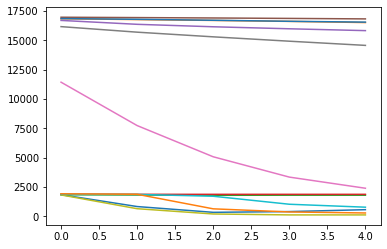

In [46]:
ax = None  # This plots everything on the same plot
for d in dfs.values():
    ax = d.val_loss.plot(ax=ax, legend=False)

In [31]:
net = Net(input_size=train_X.shape[2], 
          hidden_size = best_trial.config['hidden_size'],
          num_lstm_layers=best_trial.config['num_lstm_layers'],
          dropout= best_trial.config['dropout']
)

In [32]:
losses = []
val_losses = []
BATCH_SIZE = 8
learning_rate = best_trial.config['learning_rate']
optimizer = optim.Adam(net.parameters(), lr=learning_rate)
iter_idx = 0 
running_loss = 0
epoch_steps = 0
# train_y = tensorset.train_y
# for epoch in range(best_trial.config['epoch']):
for epoch in range(5):
    print(f"Epoch: {epoch}")
    for i in range(0, len(train_X)-BATCH_SIZE, BATCH_SIZE):
        X = train_X[i:i+BATCH_SIZE]
        y = train_y[i:i+BATCH_SIZE]
        net.zero_grad()

        out_seq = net(X)
        first_dim, second_dim, _ = out_seq.shape
        pred = out_seq.view(first_dim, second_dim)[:, -1]
        loss = F.mse_loss(pred, y)

        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        epoch_steps += 1

        # Print loss every 1000 batches
        if i % 100 == 99:
            avg_loss = running_loss / epoch_steps
            print(f"Epoch {epoch}, steps {epoch_steps-1000}:{epoch_steps} avg loss: {avg_loss}")
            running_loss = 0 
        
        
    # Validate each epoch
    val_loss = 0
    val_steps = 0
    with torch.no_grad():
        for i in range(0, len(val_X)-BATCH_SIZE, BATCH_SIZE):
            X = val_X[i:i+BATCH_SIZE]
            y = val_y[i:i+BATCH_SIZE]
            out_seq = net(X)
            first_dim, second_dim, _ = out_seq.shape
            pred = out_seq.view(first_dim, second_dim)[:, -1]
            loss = F.mse_loss(pred, y)
            val_loss += loss.item()
            val_steps += 1
        
    print("Loss:", loss)    
    print("val_loss:", val_loss)

Epoch: 0


KeyboardInterrupt: 

In [203]:
losses_plt = [i.item() for i in losses]
val_losses_vals = [i[0].item() for i in val_losses]
val_losses_idx = [i[1] for i in val_losses]

In [248]:
out_seq = net(test_X)
first_dim, second_dim, _ = out_seq.shape
pred = out_seq.view(first_dim, second_dim)[:, -1]

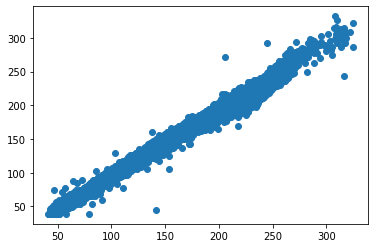

In [249]:
pred_array = pred.detach().numpy()
y = test_y.detach().numpy()
plt.scatter(pred_array, y)

In [214]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error, r2_score

In [250]:
mse = mean_squared_error(y, pred_array)
print(np.sqrt(mse))

6.5817876


In [251]:
mean_absolute_percentage_error(y, pred_array)

0.041773885

In [252]:
mean_absolute_error(y,pred_array)

4.830085